# Solving Language-related Problems with ML

### Introduction

In this tutorial we're trying to solve a (simplified but still real world) language-related problem using a Machine Learning (ML) approach. The problem is **identification of toxic language**, and can be used eg. to automoderate comments online.

In the next minutes, we're going to discuss about:

1. How this _problem_ can be thought as a ML task
2. What kind of data do we need?
3. How do these data look like?
4. How we process these data in order to be used by the computer?
5. How do we train a model?
6. How do we use this model?


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

stop_words = set(stopwords.words("english"))

# The Problem

We want to automatically detect when a message or a comment published online contains _toxic_ language, ie. when people show some kind of verbal abuse and harassment online.

How can we tackle this?


## Classification Tasks

There are different types of classification tasks:

- **Binary classification** is the classification task with just two classes.

    - true vs false
    - spam vs ham
    - cat vs not cat
    

- **Multi-class classification** means a classification task with more than two classes, each label being mutually exclusive. The classification makes the assumption that each sample is assigned to one and only one label.

    - polarity in sentiment analysis (positive, neutral, negative)
    - named entity recognition (person, organization, location, misc)
    - our macros classifier (20-something classes, mutally exclusive)


- **Multi-label classification** assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive

    - classifying movies into one or more genre(s)
    - generating automatic captions for an image


## Types of Machine Learning Approaches

Machine Learning (ML) is a programming paradigm consisting of making systems learn from experience: we teach the computer to perform a task by recognizing patterns out of data. 

Notice this is important in terms of not re-inventing the wheel, since the same code (indeed, the same learning mechanism) can be used to learn different tasks (eg. analyze sentiment analysis or identify traffic lights).

There are typically two types of ML approaches:

- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning): the data is labeled. You tell the system how to categorize the example. Given an input, the system learns how to map it to an output. The system learns to generalize and detect which inputs predict an output.


- [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning): no labels. The system is forced to figure out its own labels that better classify the data.

We'll always want to try supervised algorithms, because they perform better. A (useful) labeled dataset is a rare resource because it's expensive to create. The best datasets are manually crafted, carefully annotated and reviewed but different people in order to remove biases and to maximize the inter-annotator agreement.

There are other sub-types of ML approaches: [semi-supervised learning](https://en.wikipedia.org/wiki/Semi-supervised_learning), [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), and [generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network).


# What Do We Need Next?

Since ML implies the system learns by example, we need to provide the system a collection of examples: a dataset. In this particular case, we need a (BIG\*) collection of labeled online messages or comments containing both toxic language (referred as **positive examples**) and non-toxic language (called **negative examples**).  

At this point, we can create our own dataset. We can try to collect online messaging and anotate them by hand. And some times, that's what we'll need to do.


## You said *big*. How big is that?

Size matters, for sure. The bigger, the better. It's impossible to state a clear number, and it depends on the task. But for text classification tasks, you will tipically need examples in the order of tens of thousands. 

The size of the collection is not the only requirement. It's also important to have a dataset representative enough and with the same distribution of data than the problem you want to solve. It's also important to remove or minimize any possible biases of the data.



# Exploring the Dataset

Fortunately, we don't need to collect and annotate any set of online comments. Instead, we'll be using a public dataset, the [Jigsaw's Toxic Comments](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), a collection of Wikipedia comments which have been labeled by human raters for toxic behavior.

Our goal is to build a classifier able to assign these labels to a new message and thus detect wheter it constains toxic language or not.


Let's load the dataset and take a look at the data.

In [2]:
# load the dataset
df = pd.read_csv("data/train.csv")

print(f"{len(df)} training examples")

df.head(10)

159571 training examples


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
# let's print other examples
df[df["insult"] == 1].head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
55,0020e7119b96eeeb,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0
56,0020fd96ed3b8c8b,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0
65,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,1,0,1,0,1,0
86,0036621e4c7e10b5,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0
105,00472b8e2d38d1ea,A pair of jew-hating weiner nazi schmucks.,1,0,1,0,1,1
168,00686325bcc16080,"You should be fired, you're a moronic wimp who...",1,0,0,0,1,0
176,006b94add72ed61c,I think that your a Fagget get a oife and burn...,1,0,1,1,1,1


## Is the dataset well balanced?

In [4]:
# how many comments are there in each category?
df_toxic = df.drop(["id", "comment_text"], axis=1)
counts = []
categories = list(df_toxic.columns.values)

for i in categories:
    counts.append((i, df_toxic[i].sum()))

df_stats = pd.DataFrame(counts, columns=["category", "number_of_comments"])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5, 0, 'category')

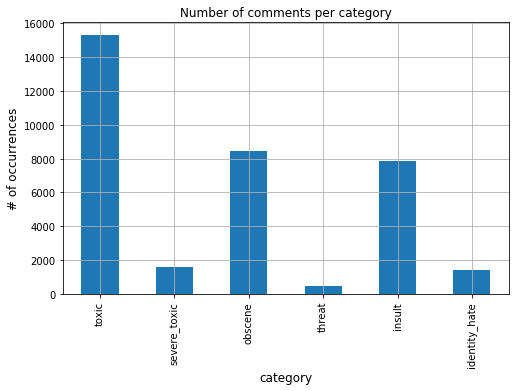

In [5]:
df_stats.plot(x="category", y="number_of_comments", kind="bar", legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel("# of occurrences", fontsize=12)
plt.xlabel("category", fontsize=12)

Text(0.5, 0, '# of categories')

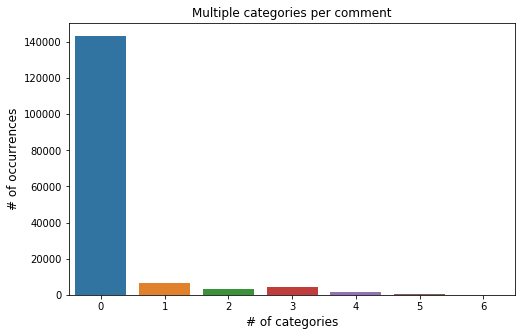

In [6]:
# how many comments have multi labels?
rowsums = df.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()
# plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel("# of occurrences", fontsize=12)
plt.xlabel("# of categories", fontsize=12)

Notice a vast majority of the comments are not labeled: they don't contain any toxic language. That0s ok, because this imbalance probably reflects what happens in the real world™.

In [7]:
not_labelled_percentage = len(
    df[(df["toxic"]==0) & 
    (df["severe_toxic"]==0) & 
    (df["obscene"]==0) & 
    (df["threat"]== 0) & 
    (df["insult"]==0) & 
    (df["identity_hate"]==0)]) / len(df)

print(f"Percentage of comments that are not labelled: {not_labelled_percentage:.2f}")

Percentage of comments that are not labelled: 0.90


## How do the Comments Look Like?

min chars per msg: 6
avg chars per msg: 394.0732213246768
max chars per msg: 5000
std chars per msg: 590.7202819048919


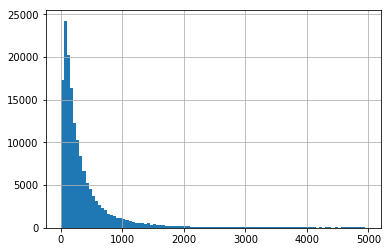

In [8]:
message_lengths = df["comment_text"].str.len()

print(f"min chars per msg: {message_lengths.min()}")
print(f"avg chars per msg: {message_lengths.mean()}")
print(f"max chars per msg: {message_lengths.max()}")
print(f"std chars per msg: {message_lengths.std()}")

message_lengths.hist(bins = np.arange(0,5000,50))

# Processing the Data

## Tokenization

We need to identify the minimal units we're dealing with. Tokenization is the process consisting of chopping the string of text in individual units (or tokens).

In [9]:
sentence = "Wanna have #fun with @johndoe?? Listen to Win $1000 Every Hour! More info --> http://url.co/havefun"

In [10]:
import re, string

re_tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])")

def tokenize(s): 
    return re_tok.sub(r" \1 ", s).split()

print(tokenize(sentence))

['Wanna', 'have', '#', 'fun', 'with', '@', 'johndoe', '?', '?', 'Listen', 'to', 'Win', '$', '1000', 'Every', 'Hour', '!', 'More', 'info', '-', '-', '>', 'http', ':', '/', '/', 'url', '.', 'co', '/', 'havefun']


In [11]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

print(tokenizer.tokenize(sentence))

['Wanna', 'have', '#fun', 'with', '@johndoe', '?', '?', 'Listen', 'to', 'Win', '$', '1000', 'Every', 'Hour', '!', 'More', 'info', '-->', 'http://url.co/havefun']


## Train and Validation Set

It's common use in ML to split the dataset into two different subsets:

- a **training set**, which is used for training, and;
- a **validation set**, which YOU NEVER LOOK, and is used to evaluate the performance of the system.

In [12]:
categories = list(df.columns.values)[2:]
print(categories)

train, validation = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train["comment_text"]
X_valid = validation["comment_text"]
print(X_train.shape)
print(X_valid.shape)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(106912,)
(52659,)


## Vectorization

Computers don't really understand words. They just pretend they understand language. As you probably know, we need to represent the texts as a bunch of numbers, so that computers can identify patterns. Indeed, we want the computer to map recurring patterns as target labels.

Thus, we call **vectorization** the process consisting of representing text as (hopefully) meaningful vectors of numbers.

In [13]:
count_vectors = CountVectorizer(ngram_range=(1,2), tokenizer=tokenize, strip_accents="unicode")

train_term_count = count_vectors.fit_transform(X_train)
test_term_count = count_vectors.transform(X_valid)

train_term_count

<106912x1691567 sparse matrix of type '<class 'numpy.int64'>'
	with 13304364 stored elements in Compressed Sparse Row format>

In [14]:
v = train_term_count[0, :].toarray()

# compute the most common value
c = Counter(v[0])
print(c.most_common(1))

print(f"min: {v.min()}")
print(f"avg: {v.mean()}")
print(f"max: {v.max()}")
print(f"std: {v.std()}")
print(f"mode: {c.most_common(1)}")

[(0, 1691493)]
min: 0
avg: 5.024926591734173e-05
max: 3
std: 0.008027127067160227
mode: [(0, 1691493)]


In [15]:
tfidf_vectors = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenizer.tokenize, strip_accents="unicode")

train_term_tfidf = tfidf_vectors.fit_transform(X_train)
test_term_tfidf = tfidf_vectors.transform(X_valid)

train_term_tfidf

<106912x1779073 sparse matrix of type '<class 'numpy.float64'>'
	with 12751712 stored elements in Compressed Sparse Row format>

In [16]:
v = train_term_tfidf[0, :].toarray()

# compute the most common value
c = Counter(v[0])
print(c.most_common(1))

print(f"min: {v.min()}")
print(f"avg: {v.mean()}")
print(f"max: {v.max()}")
print(f"std: {v.std()}")
print(f"mode: {c.most_common(1)}")

[(0.0, 1778999)]
min: 0.0
avg: 4.45835589933696e-06
max: 0.2407144923225119
std: 0.0007497136820252882
mode: [(0.0, 1778999)]


## Train your First Model: a NB Classifier


In [17]:
# Define a pipeline combining a text feature extractor with a Naive Bayes classifier
NB_pipeline = Pipeline([
                ("tfidf", TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)),
                ("clf", OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print(f"Processing {category}...")
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_valid)
    print(f"Test accuracy: {accuracy_score(validation[category], prediction)}")

Processing toxic...
Test accuracy: 0.9162536318578021
Processing severe_toxic...
Test accuracy: 0.9900112041626312
Processing obscene...
Test accuracy: 0.950075010919311
Processing threat...
Test accuracy: 0.9971324939706413
Processing insult...
Test accuracy: 0.9510245162270458
Processing identity_hate...
Test accuracy: 0.9910556600011394


## Train a Second One: an SVM Classifier

In [18]:
# Define a pipeline combining a text feature extractor with an SVM classifier
SVC_pipeline = Pipeline([
                ("tfidf", TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)),
                ("clf", OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
for category in categories:
    print(f"Processing {category}...")
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_valid)
    print(f"Test accuracy: {accuracy_score(validation[category], prediction)}")

Processing toxic...
Test accuracy: 0.9603296682428455
Processing severe_toxic...
Test accuracy: 0.9904479766041893
Processing obscene...
Test accuracy: 0.9788450217436715
Processing threat...
Test accuracy: 0.9973413851383429
Processing insult...
Test accuracy: 0.9707362464156175
Processing identity_hate...
Test accuracy: 0.9921760762642663


# Consuming the Models


In [19]:
# let's train the classifiers and persist the models
models = {}

#Consuming-the-Models
for category in categories:
    models[category] = Pipeline([
                ("tfidf", TfidfVectorizer(tokenizer=tokenizer.tokenize, stop_words=stop_words)),
                ("clf", OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

    print(f"Traing a classifier for {category}... ", end="")
    models[category].fit(X_train, train[category])
    print(" Done!")

Traing a classifier for toxic...  Done!
Traing a classifier for severe_toxic...  Done!
Traing a classifier for obscene...  Done!
Traing a classifier for threat...  Done!
Traing a classifier for insult...  Done!
Traing a classifier for identity_hate...  Done!


In [20]:
def predict_toxic_language(message):
    is_toxic = False
    print(message)
    for category in categories:
        if models[category].predict([message]):
            print(category)
            is_toxic = True
    if is_toxic == False:
        print("The message is safe. No toxic language.")
    print()

In [21]:
# let's see how it predicts the toxic categories
predict_toxic_language("Hello, sir. How is your day?")
predict_toxic_language("You fucking idiot!!")
predict_toxic_language("Only nigga that I trust is me")

Hello, sir. How is your day?
The message is safe. No toxic language.

You fucking idiot!!
toxic
obscene
insult

Only nigga that I trust is me
toxic
identity_hate



## A Quick and Dirty Demo

In [22]:
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)
                                
@register_cell_magic
def analyze(line, message):
    predict_toxic_language(message)

In [24]:
%%analyze
C'mon baby, light my fire

C'mon baby, light my fire

The message is safe. No toxic language.



In [25]:
%%analyze
You're FUCKING awesome!! :-)

You're FUCKING awesome!! :-)

toxic
obscene
insult



In [26]:
%%analyze
I'm not a racist but

I'm not a racist but

toxic

